In [3]:
import numpy as np
import scipy.sparse as sp
import time
import os
import psutil
import shelve
from pybdm import BDM
from pybdm.utils import decompose_dataset
from joblib import Parallel, delayed
from node import NodePerturbationExperiment
from pybdm.algorithms import PerturbationExperiment

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
np.random.seed(303)
X = np.random.randint(0,2,(10,10))
bdm = BDM(ndim=2)

In [22]:
edge_exp = PerturbationExperiment(bdm,X)

In [23]:
value = edge_exp.run()

In [24]:
print(value.shape)
print(np.sum(X))
print(X.size)

(100,)
48
100


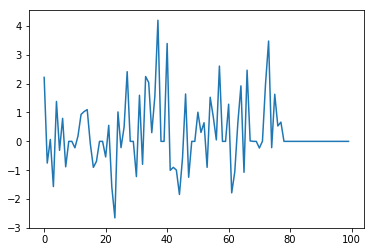

In [25]:
plot(value)

## Tests parallelization node experiments

In [40]:
np.random.seed(303)
X = np.random.randint(0,2,(500,300))
bdm = BDM(ndim=2)

In [31]:
start = time.time()
val = bdm.ent(X)
print(time.time()-start)
print(val)

0.7765731811523438
15.138817770314766


In [34]:
start = time.time()
counters = Parallel(n_jobs=8) \
    (delayed(bdm.decompose_and_count)(d) for d in decompose_dataset(X, (500, 500)))
val = bdm.compute_ent(*counters)
print(time.time()-start)
print(val)

1.3946480751037598
15.13881777031484


In [42]:
test_series = NodePerturbationExperiment(bdm,X,metric='bdm',bipartite_network=True)

In [43]:
start = time.time()
nodes = test_series.run()
print(time.time()-start)
print(nodes[0])

106.59811019897461
[-2502.99336418 -2665.67638292 -2595.89034274 -2430.39320893
 -2387.64472993 -2415.79444157 -2292.69529415 -2366.67188263
 -2293.21098348 -2453.29968812 -2485.82252648 -2465.40498313
 -2376.01531059 -2295.82500859 -2290.90382801 -2354.91121096
 -2234.01412518 -2337.50366428 -2171.37650335 -2264.21491465
 -2133.9817092  -2050.58786022 -2076.51477905 -2038.19564505
 -2080.17806743 -2063.93377436 -2154.89118872 -2201.14913354
 -2281.48023016 -2087.49209095 -2107.0858089  -2102.82051511
 -2317.46220662 -2131.5904891  -2203.29244995 -2330.66288316
 -2232.774656   -2359.74033081 -2300.0524727  -2330.93877381
 -2404.43273015 -2526.85090161 -2514.13916276 -2477.98091391
 -2732.80706389 -2542.16503012 -2715.92985084 -2813.11839479
 -2745.90270219 -2866.36631391 -2826.89010394 -2994.96192661
 -2790.40855949 -2934.96113638 -2909.46989194 -3030.43132336
 -2946.93354341 -3064.94928758 -3086.45517775 -3075.86689344
 -3170.54484611 -3175.70915572 -3117.82497467 -3088.73017853
 -313

In [45]:
test_parallel = NodePerturbationExperiment(bdm,X,parallel=True, jobs=8,bipartite_network=True)

In [46]:
start = time.time()
nodes = test_parallel.run()
print(time.time()-start)
print(nodes[0])

110.483962059021
[-2502.993364184571, -2665.676382917969, -2595.8903427443583, -2430.3932089326554, -2387.6447299323627, -2415.7944415729726, -2292.695294146659, -2366.671882628929, -2293.210983480967, -2453.2996881167637, -2485.8225264832145, -2465.404983127315, -2376.0153105899226, -2295.825008587679, -2290.9038280148525, -2354.911210960592, -2234.0141251808964, -2337.503664279182, -2171.376503349107, -2264.214914653683, -2133.9817091960576, -2050.587860221276, -2076.514779050718, -2038.1956450496218, -2080.1780674253823, -2063.9337743627257, -2154.891188715992, -2201.1491335360333, -2281.480230156041, -2087.492090947693, -2107.0858089042013, -2102.8205151141156, -2317.462206617056, -2131.590489101596, -2203.2924499482033, -2330.662883163546, -2232.7746559970547, -2359.7403308125213, -2300.0524727038573, -2330.938773811504, -2404.4327301546, -2526.850901608239, -2514.139162763837, -2477.9809139115387, -2732.807063891494, -2542.1650301241316, -2715.929850837332, -2813.118394785095, -2